In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from wordcloud import WordCloud

from collections import Counter

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('russian')
stop_words.extend(['это', 'который', 'также'])

import re
import pymorphy3

import gensim
import gensim.corpora as corpora
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Преобразование датафрейма в корпус текстов

In [3]:
df = pd.read_csv('../data/MedDataset.csv')

In [4]:
df = df.drop('category', axis=1)

In [5]:
df = df.melt(id_vars=['label']).dropna().drop('variable', axis=1)

In [6]:
corp = df['value'].to_list()

In [7]:
def record_file(file: str, lst: list[str]) -> None:
    """
    Записывает в файл информацию из списка
    :param file: путь до файла
    :param lst: список строк
    """
    with open(file, 'w', encoding='utf-8') as f:
        for comment in lst:
            comment = comment.replace('\n', ' ')
            f.write(comment + '\n')

In [8]:
record_file('../data/description.txt', corp)

# 2. Препроцессинг

In [9]:
def txt_file_to_list(file: str) -> list:
    """
    Преобразует информацию из файла в список, деля ее построчно
    :param file: путь до файла
    """
    with open(file, 'r', encoding='utf-8') as f:
        lst = f.readlines()
        lst = [i.strip() for i in lst]

    return lst

In [10]:
corp = txt_file_to_list('../data/description.txt')

In [11]:
def drop_duplicates(lst: list) -> list:
    """
    Удаление дубликатов из списка
    :params lst: список с дубликатами
    :return: список без дупликатов
    """
    return list(set(lst))

In [12]:
# В файле при парсинге сложились дупликаты комментариев, удалим их
corp = drop_duplicates(corp)

In [13]:
def drop_empty_elements(lst: list[str]) -> list[str]:
    """
    Удаление пустых строк из списка
    :params lst: список с пустыми строками
    :return: список без пустых строк
    """
    while True:
        try:
            lst.remove('')
        except ValueError:
            break
    
    return lst

In [14]:
# В списке есть пустые строки, которые мешают дальнейшей обработке. Удалим их.
corp = drop_empty_elements(corp)

In [15]:
def preprocess_text(
        text: str, stopwords: list[str] = stop_words
    ) -> str:
    """
    Очистка текста и удаление стоп-слов
    :params text: необработанная строка
    :params stopwords: список стоп-слов (по умолчанию русские стоп-слова)
    :return: строка после обработки
    """
    text = re.sub('ё', 'е', text.lower())
    text = re.sub(r'([.,!?-])', r' \1 ', text)
    text = re.sub(r'[^а-яА-Я\s]+', '', text)
    text = text.strip()
    text = [i for i in text.split() if i not in stopwords]
    text = [i for i in text if len(i) >= 3]
    text = ' '.join(text)

    return text


def lemmatization_text(text: str) -> str:
    """
    Приведение слов в строке к начальной форме
    :params text: необработанная строка
    :return: обработанная строка
    """
    morph = pymorphy3.MorphAnalyzer()
    text = ' '.join(morph.parse(i)[0].normal_form for i in text.split())

    return text


In [16]:
def list_with_strings_preproc(
        lst: list[str], preprocessor, lemmatizator
    ) -> list[str]:
    """
    Удаление стоп-слов, приведение слов в строке в списке к начальной форме
    и удаление из списка NaN и пустых строк
    :params lst: список с необработанными строками
    :params preprocessor: функция, очищающая строку и удаляющая стоп-слова
    :params lemmatizator: функция, приводящая слова в строке к начальной форме
    :return: список с обработанными строками
    """
    for i in range(len(lst)):
        lst[i] = preprocessor(lst[i])
        lst[i] = lemmatizator(lst[i])
        lst[i] = preprocessor(lst[i])
    lst = [i for i in lst if i not in [None, '']]
    return lst

In [17]:
corp = list_with_strings_preproc(corp, 
                                 preprocess_text, 
                                 lemmatization_text)

In [18]:
# Сохраню полученные комментарии в файл
record_file('../data/corp_preprocessed.txt', corp)

# 3. EDA. Тематическое моделирование.

In [20]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words = list(sent_to_words(corp))

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts):
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]  
    return texts

data_ready = process_words(data_words)

In [ ]:
id2word = corpora.Dictionary(data_ready)

corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=corp):
    """Формирование таблицы с ключевыми словами по каждому топику"""
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([int(topic_num), round(prop_topic,4), topic_keywords])], 
                                           axis=1, ignore_index=True)
            else:
                break
    sent_topics_df = sent_topics_df.T
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

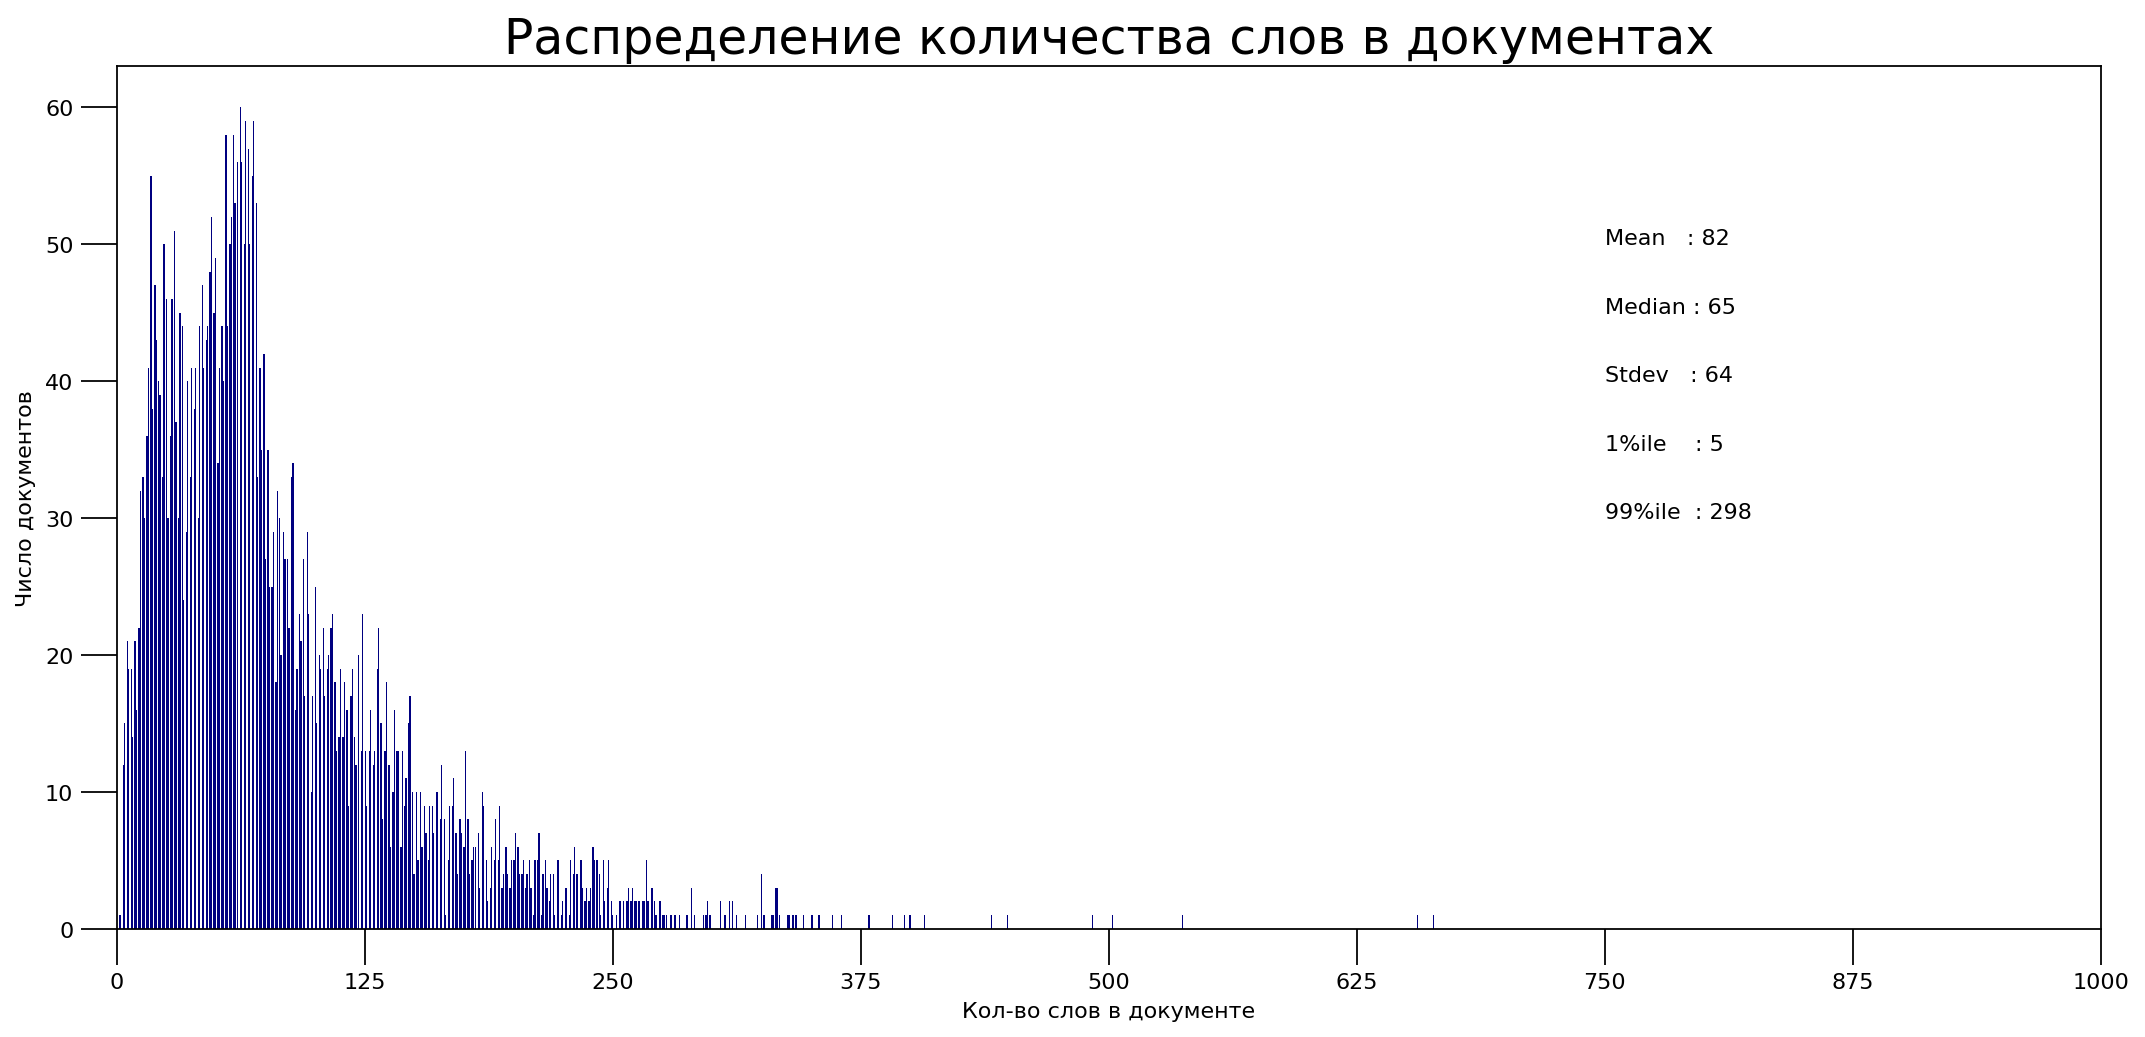

In [35]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 50, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 45, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 40, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 35, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 30, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Число документов', xlabel='Кол-во слов в документе')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Распределение количества слов в документах', fontdict=dict(size=22))
plt.show()

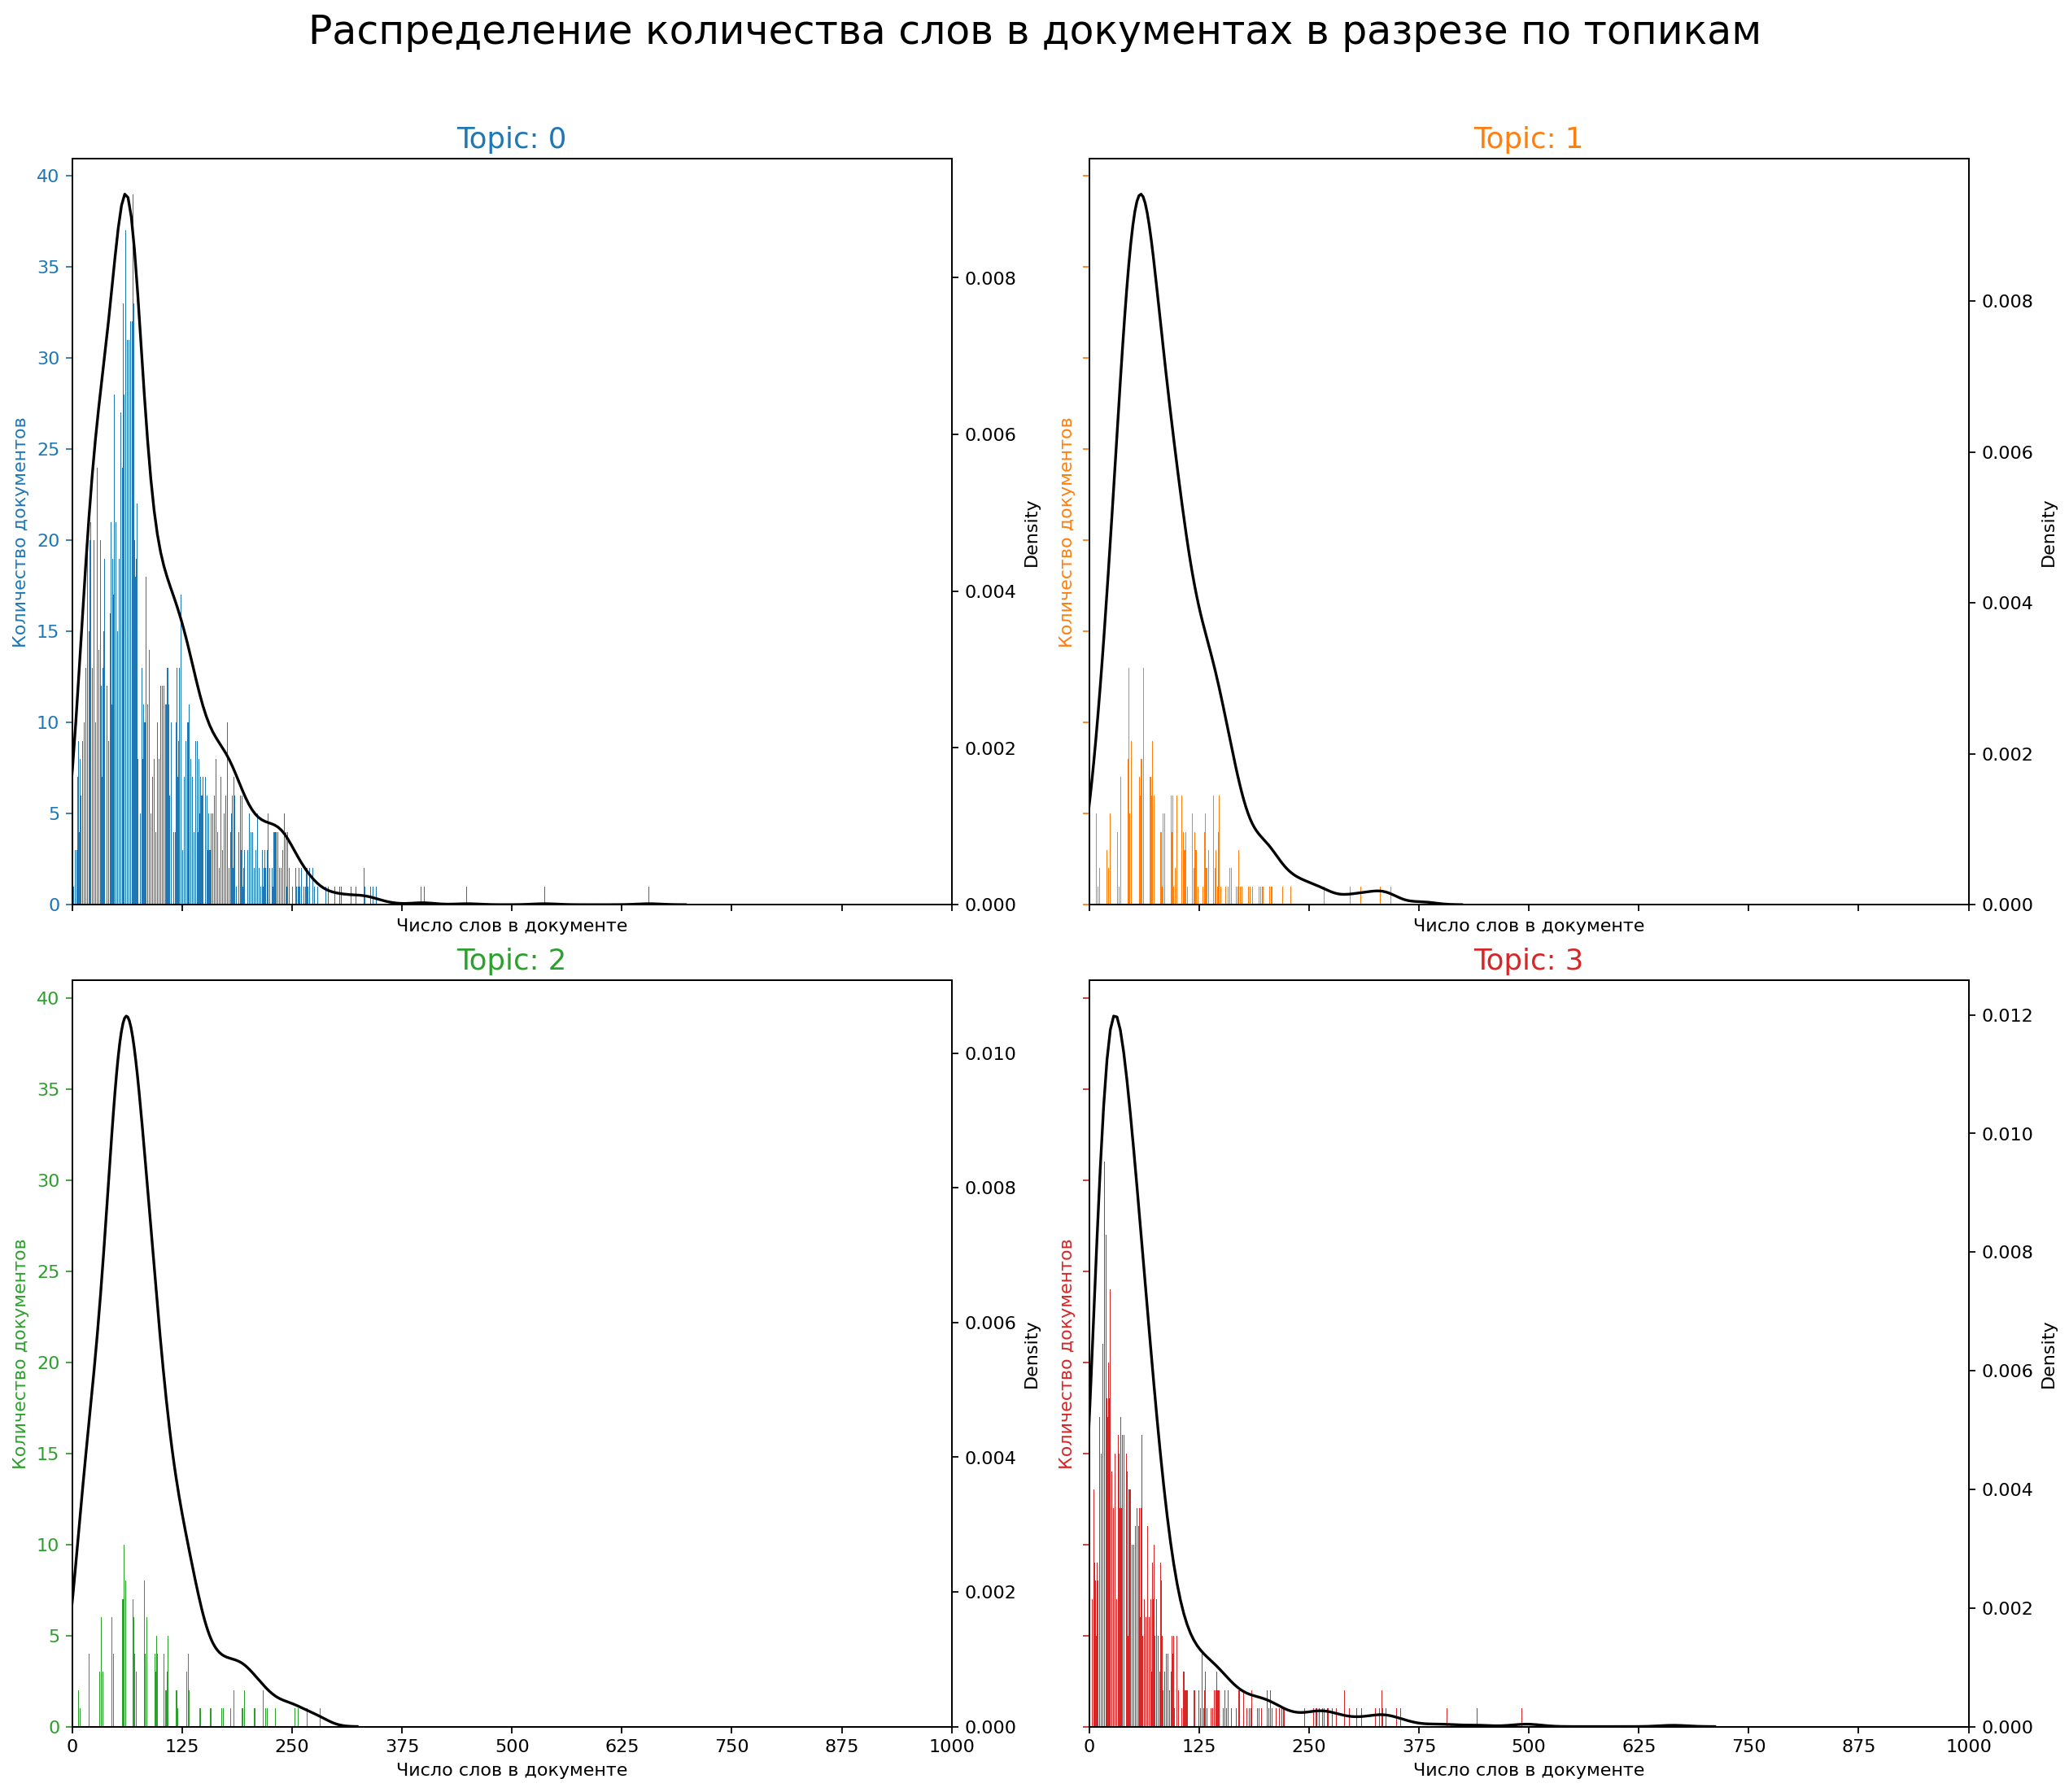

In [36]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Число слов в документе')
    ax.set_ylabel('Количество документов', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Распределение количества слов в документах в разрезе по топикам', fontsize=22)
plt.show()

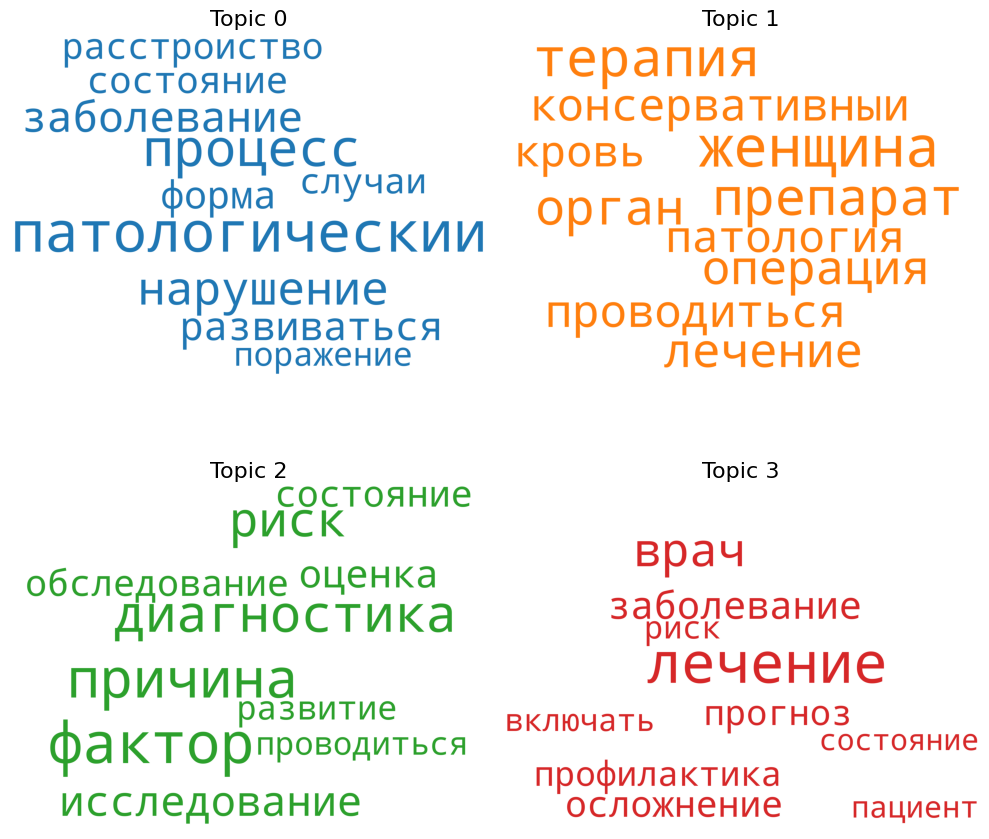

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

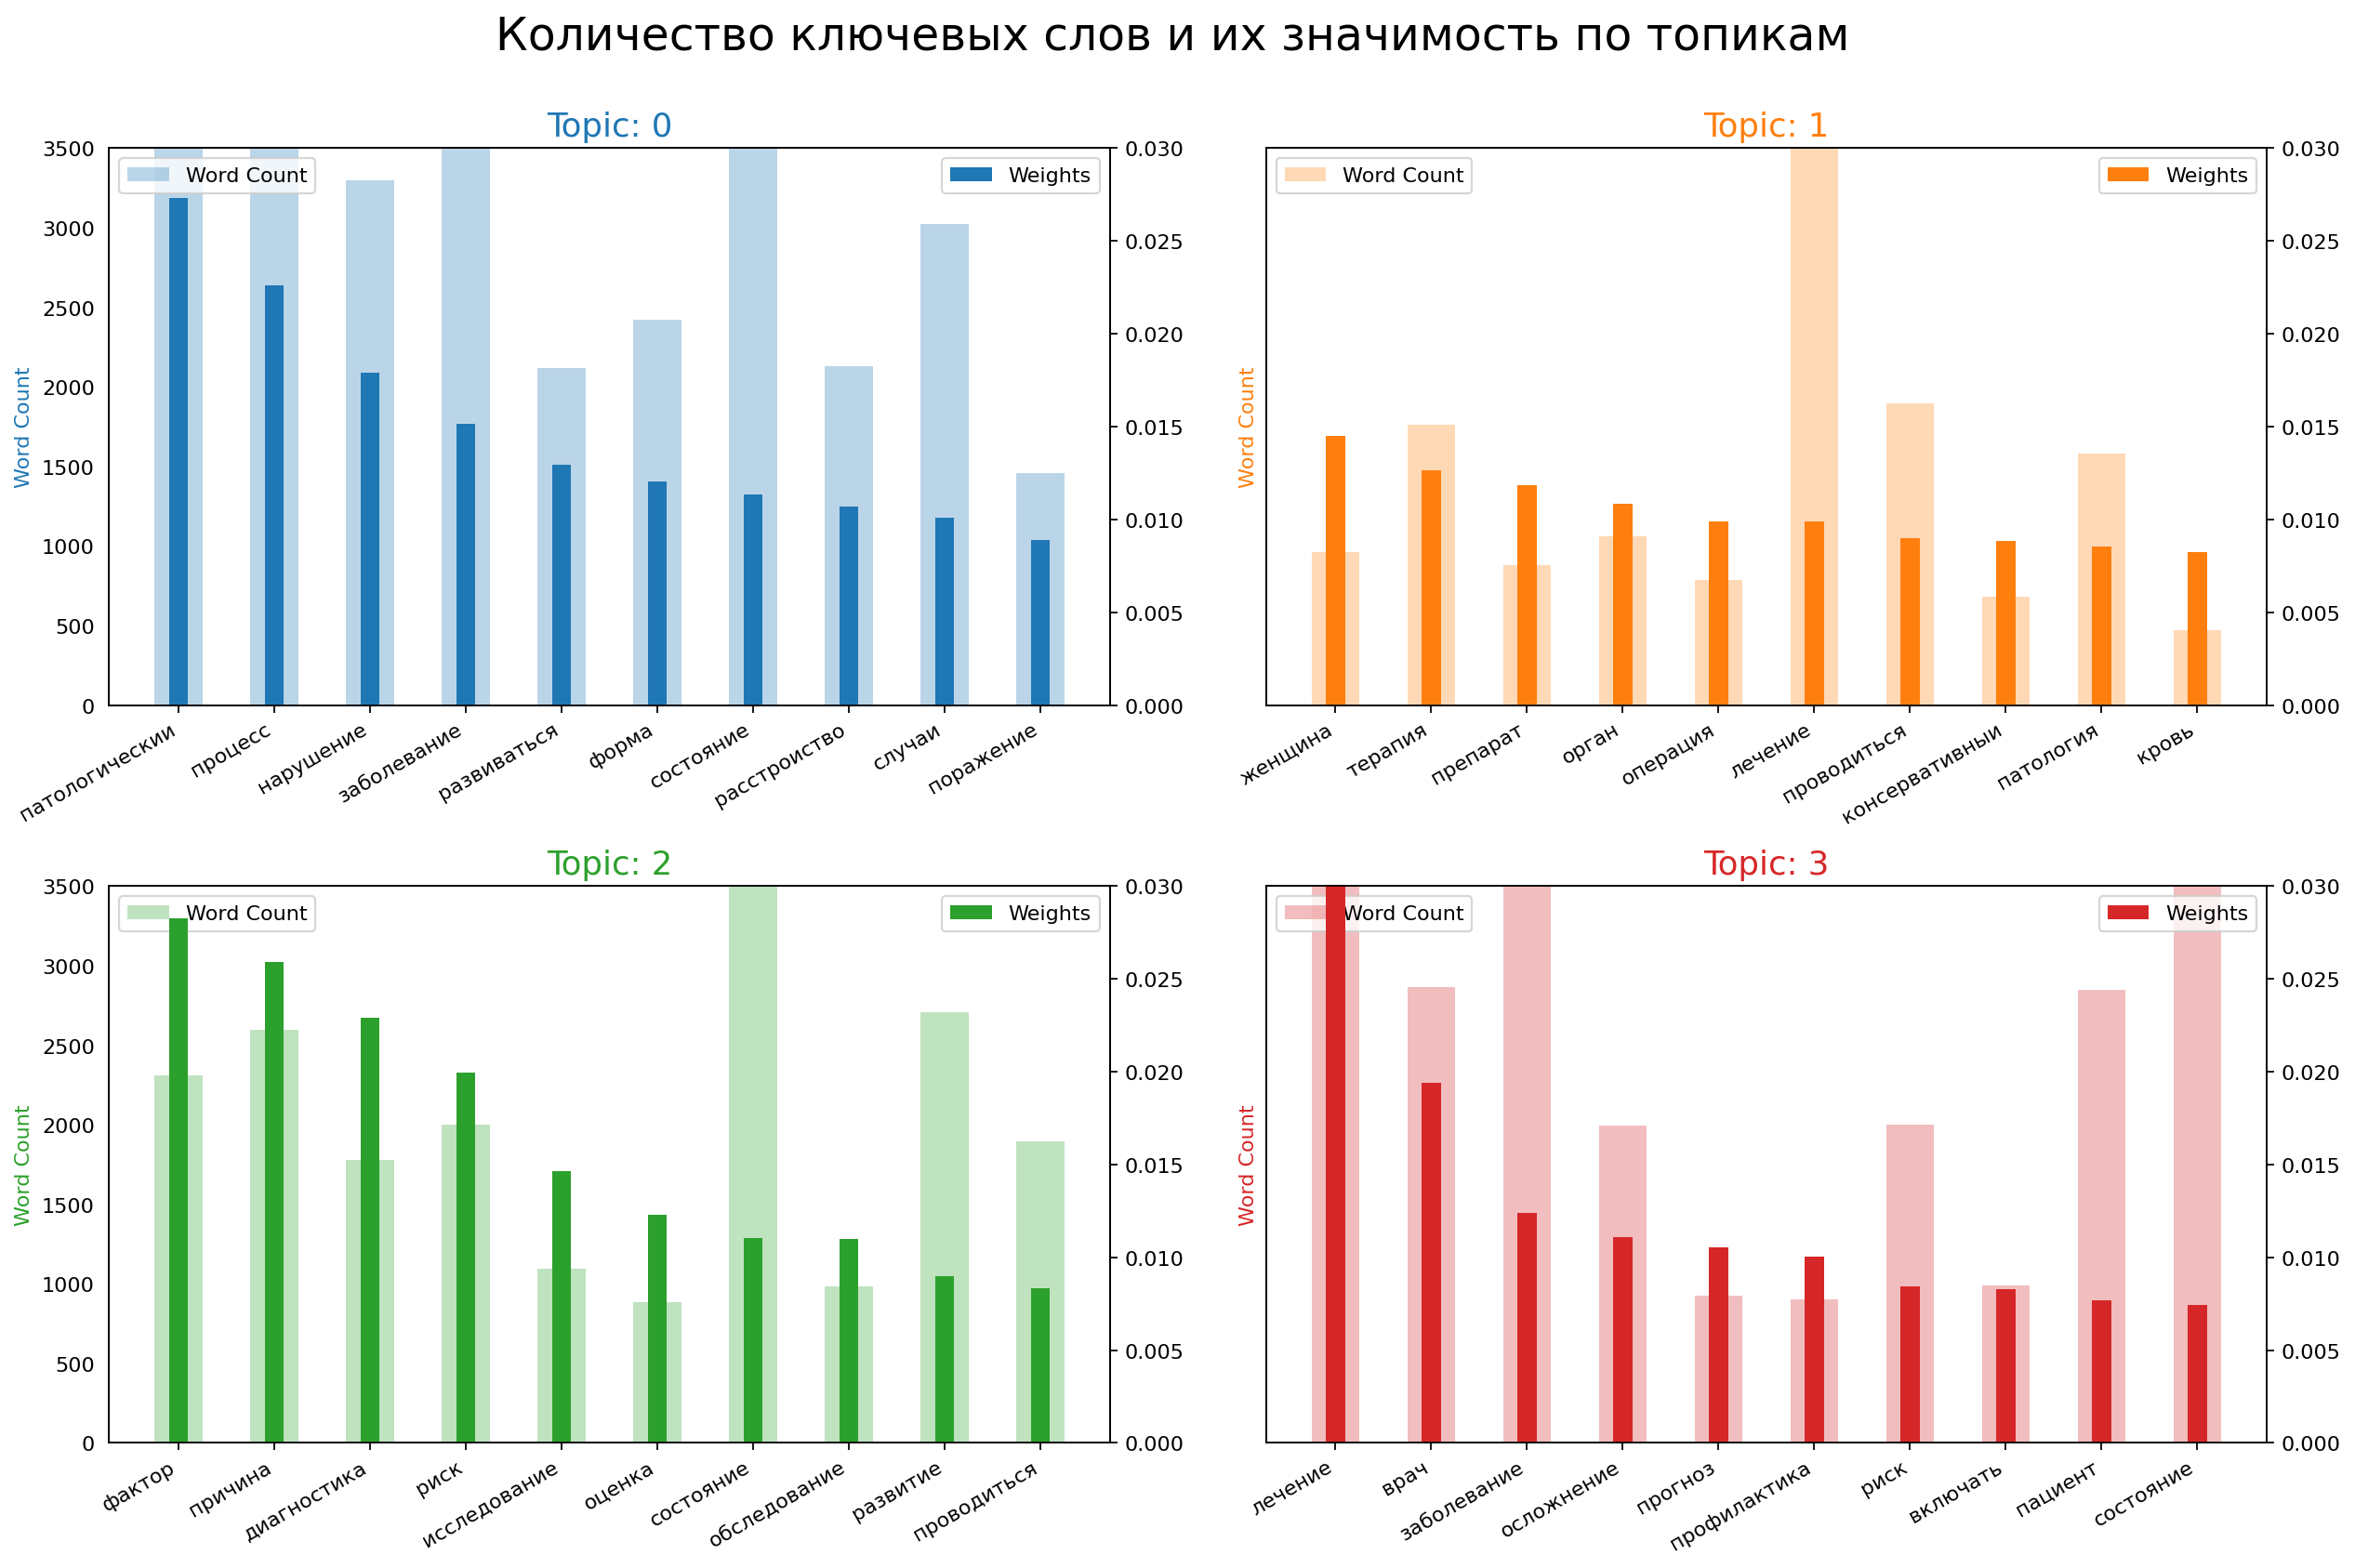

In [37]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Количество ключевых слов и их значимость по топикам', fontsize=22, y=1.05)    
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4819 samples in 0.007s...
[t-SNE] Computed neighbors for 4819 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4819
[t-SNE] Computed conditional probabilities for sample 2000 / 4819
[t-SNE] Computed conditional probabilities for sample 3000 / 4819
[t-SNE] Computed conditional probabilities for sample 4000 / 4819
[t-SNE] Computed conditional probabilities for sample 4819 / 4819
[t-SNE] Mean sigma: 0.033361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.012947
[t-SNE] KL divergence after 1000 iterations: 0.944292


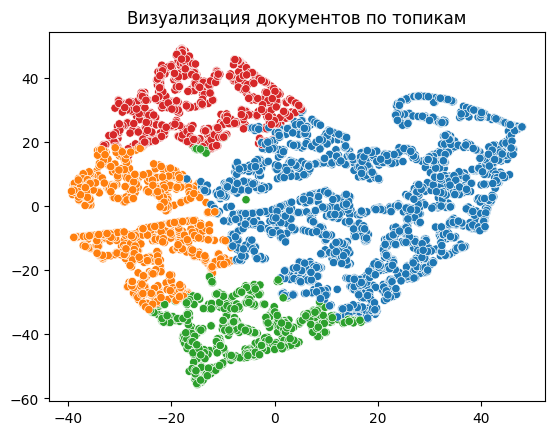

In [43]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

arr = pd.DataFrame(topic_weights).fillna(0).values

arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.title('Визуализация документов по топикам')
plt.show()